max_likrat() = 2.6180339887498945
max_likrat_optim() = 2.618033988749895
min_likrat() = 0.3819660112501052
min_likrat_optim() = 0.38196601125010515



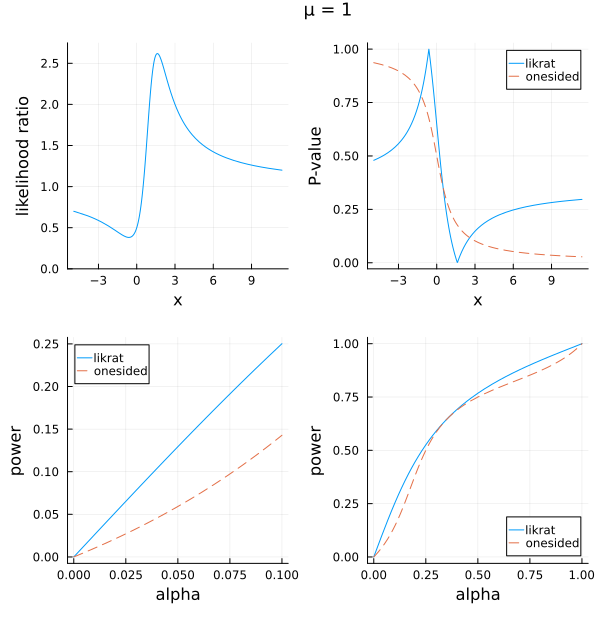

In [1]:
using Distributions
using Optim: optimize
using Roots
using StatsPlots
default(fmt=:png)

x ⪅ y = x < y || x ≈ y

likrat(x; μ=1) = exp(logpdf(Cauchy(μ), x) - logpdf(Cauchy(), x))

function min_likrat_optim(; μ=1)
    f(x) = likrat(x; μ)
    o = optimize(f, -1.0, 0.0)
    likrat(o.minimizer)
end

function max_likrat_optim(; μ=1)
    f(x) = -likrat(x; μ)
    o = optimize(f, 0.0, 2μ)
    likrat(o.minimizer)
end

argmin_likrat(; μ=1) = (μ - √(μ^2 + 4)) / 2
argmax_likrat(; μ=1) = (μ + √(μ^2 + 4)) / 2
min_likrat(; μ=1) = likrat(argmin_likrat(; μ); μ)
max_likrat(; μ=1) = likrat(argmax_likrat(; μ); μ)

@show max_likrat() max_likrat_optim()
@show min_likrat() min_likrat_optim()
println()

function rejprob_likrat(λ; μ=1, dist=Cauchy())
    @assert μ > 0
    a = argmin_likrat(; μ)
    b = argmax_likrat(; μ)
    f(x) = likrat(x; μ) - λ
    if likrat(b; μ) ⪅ λ
        0.0
    elseif λ ⪅ likrat(a; μ)
        1.0
    elseif λ ≈ 1
        c = find_zero(f, (a, b))
        ccdf(dist, c)
    elseif 1 < λ
        c = find_zero(f, (a, b))
        d = find_zero(f, b+1)
        cdf(dist, d) - cdf(dist, c)
    elseif λ < 1
        c = find_zero(f, (a, b))
        d = find_zero(f, a-1)
        cdf(dist, d) + ccdf(dist, c)
    end
end

function lambda_likrat(α; μ=1)
    1 ⪅ α && return min_likrat(; μ)
    α ⪅ 0 && return max_likrat(; μ)
    f(λ) = rejprob_likrat(λ; μ) - α
    find_zero(f, (min_likrat(; μ), max_likrat(; μ)))
end

function power_likrat(α; μ=1)
    λ = lambda_likrat(α; μ)
    rejprob_likrat(λ; μ, dist=Cauchy(μ))
end

function power_onesided(α; μ=1)
    x = cquantile(Cauchy(), α)
    ccdf(Cauchy(μ), x)
end

function pvalue_likrat(x; μ=1)
    λ = likrat(x; μ)
    rejprob_likrat(λ; μ)
end

function pvalue_onesided(x; μ=1)
    ccdf(Cauchy(), x)
end

function plot_likrattest(; μ=1)
    a = argmin_likrat(; μ)
    b = argmax_likrat(; μ)
    f(x) = likrat(x; μ) - 0.7
    g(x) = likrat(x; μ) - 1.2
    c = find_zero(f, a-1)
    d = find_zero(g, b+1)
    
    P1 = plot(x -> likrat(x; μ), c, d;
        label="", ylim=(0, 1.05max_likrat(; μ)))
    plot!(xguide="x", yguide="likelihood ratio")
    
    #P2 = plot(λ -> rejprob_likrat(λ; μ), min_likrat(; μ), max_likrat(; μ); label="")
    #plot!(xguide="lambda", yguide="alpha")
    
    #P3 = plot(α -> lambda_likrat(α; μ), 0, 1; label="")
    #plot!(xguide="alpha", yguide="lambda")
    
    P4 = plot(α -> power_likrat(α; μ), 0, 1; label="likrat")
    plot!(α -> power_onesided(α; μ); label="onesided", ls=:dash)
    plot!(xguide="alpha", yguide="power")
    plot!(legend=:bottomright)
    
    P3 = plot(α -> power_likrat(α; μ), 0, 0.1; label="likrat")
    plot!(α -> power_onesided(α; μ); label="onesided", ls=:dash)
    plot!(xguide="alpha", yguide="power")
    
    P2 = plot(x -> pvalue_likrat(x; μ), c, d; label="likrat")
    plot!(x -> pvalue_onesided(x; μ), c, d; label="onesided", ls=:dash)
    plot!(xguide="x", yguide="P-value")
    
    plot(P1, P2, P3, P4; size=(600, 620), layout=(2, 2))
    plot!(plot_title="μ = $μ", plot_titlefontsize=12)
end

plot_likrattest(; μ=1)

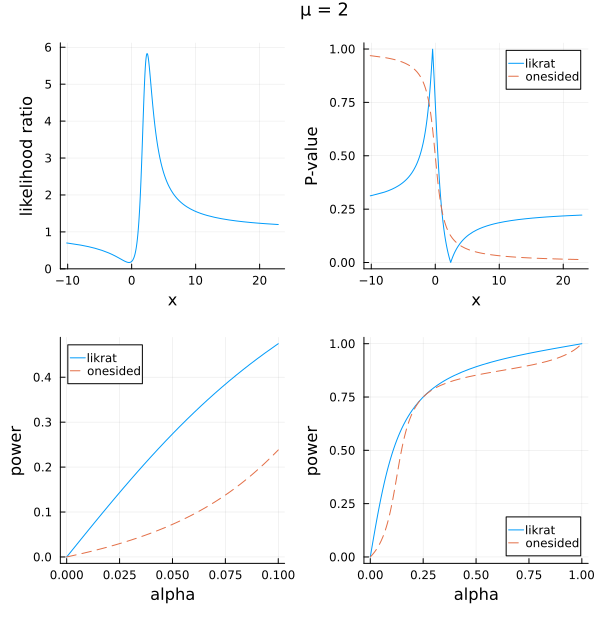

In [2]:
plot_likrattest(; μ=2)

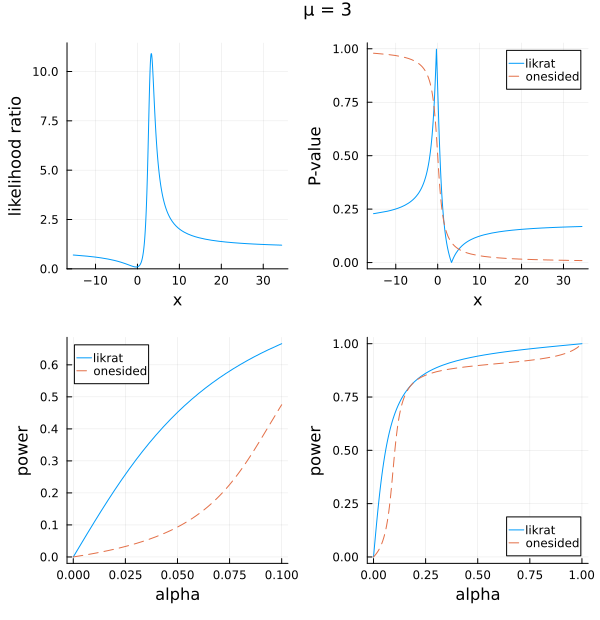

In [3]:
plot_likrattest(; μ=3)

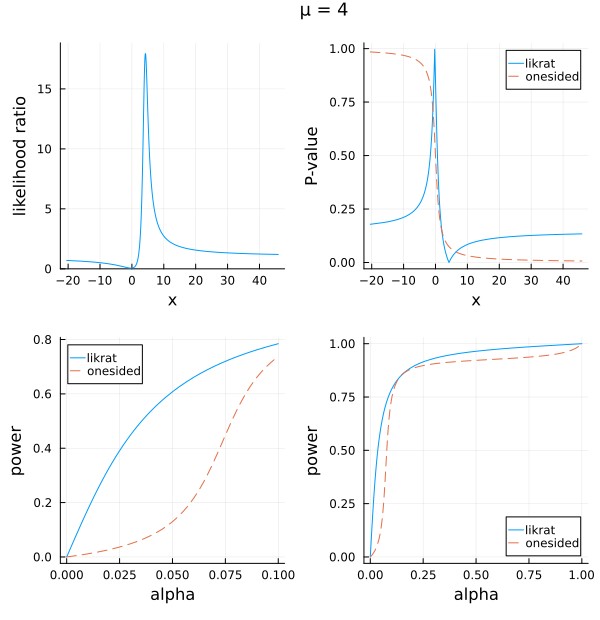

In [4]:
plot_likrattest(; μ=4)

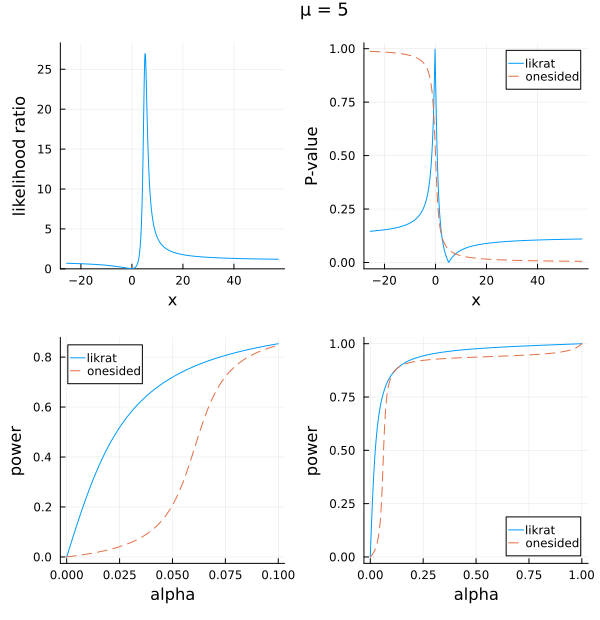

In [5]:
plot_likrattest(; μ=5)

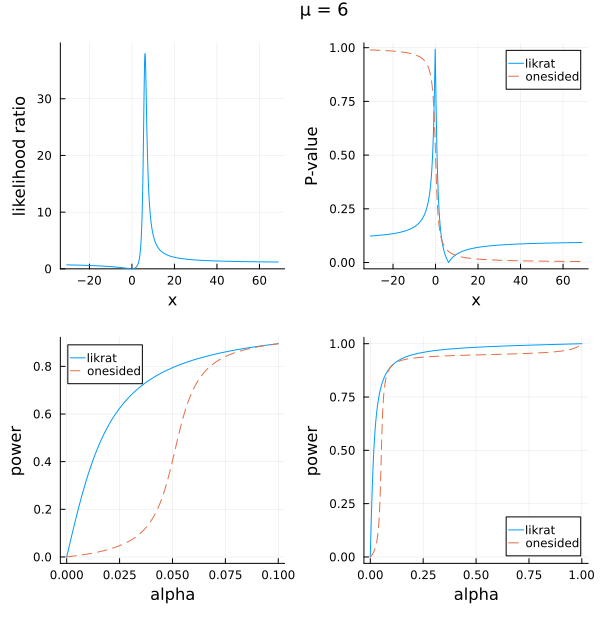

In [6]:
plot_likrattest(; μ=6)